DISCLAIMER: This code was done on Google collab with permission from the instructor. However, let it be known that Google collab has an auto fill feature (similar to that of Gmail autofill or on Google docs where it finishes sentences for you), which could autofill the code. I wasn't able to find the setting to turn it off, however, I tried my best to adhere to the academic honesty policies. Wherever autofill was used, I have cited it, but also primarily because it made sense to do the code that way.
However, all points of academic honesty was honored.
(References listed on the report)

In [31]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [1]:
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
df.head()

Saving All_Filled_Car_Data.csv to All_Filled_Car_Data.csv


,Year,Brand,Car Model,Trim,Drive Train,Fuel Type,Engine Type (Cyl),Engine Type (L),Battery (kWh),Mileage,Fuel (City/HWY),Car Dealer Location,Price,Reference link
0,2010,Scion,xB,NaN,FWD,Gasoline,4.0,2.0,0.0,253000.0,24/33,"Auburn, 98002",4500,https://revyautos.com/listings/1jqhwmg540z7fh3...
1,2007,Audi,S6,4D Sedan Quattro,FWD,Gasoline,4.0,2.0,0.0,135000.0,24/33,"Woodinville, WA",6900,https://privateauto.com/listing/2007-audi-s6-v...
2,2009,BMW,5-Series,528xi,FWD,Gasoline,4.0,2.0,0.0,202744.0,24/33,"Snohomish, WA",5600,https://privateauto.com/listing/2009-bmw-5-ser...
3,2016,Lexus,IS,350 4D Sedan,FWD,Gasoline,4.0,2.0,0.0,98900.0,24/33,"Seattle, WA",24900,https://privateauto.com/listing/2016-lexus-is-...
4,2019,Mercedes-Benz,AMG,GT 53,FWD,Gasoline,4.0,2.0,0.0,41826.0,24/33,"Renton, WA",52000,https://privateauto.com/listing/2019-mercedes-...


In [40]:
data = pd.read_csv('All_Filled_Car_Data.csv')
# Drop unwanted columns
columns_to_drop = ['Car Model', 'Trim', 'Reference link', 'Car Dealer Location', 'Engine Type (Cyl)', 'Engine Type (L)', 'Battery (kWh)']
for col in columns_to_drop:
    if col in data.columns:
        data.drop(columns=[col], inplace=True)
# Drop rows with missing values
data.dropna(inplace=True)
if 'Fuel (City/HWY)' in data.columns:
    fuel_split = data['Fuel (City/HWY)'].str.split('/', expand=True)
    data['City_MPG'] = fuel_split[0].astype(float)
    data['Hwy_MPG'] = fuel_split[1].astype(float)
    data.drop(columns=['Fuel (City/HWY)'], inplace=True)
data['Car_Age'] = 2025 - data['Year']
data.drop(columns=['Year'], inplace=True)
data['Mileage_Band'] = pd.cut(data['Mileage'], bins=[-1, 30000, 70000, 300000], labels=['Low', 'Medium', 'High'])
data = data[(data['Price'] < 150000) & (data['Mileage'] < 200000)]
print("Cleaned dataset shape:", data.shape)
#Reference: https://stackoverflow.com/questions/48899051/how-to-drop-a-specific-column-of-csv-file-while-reading-it-using-pandas

Cleaned dataset shape: (899, 9)


In [39]:
# Separate features and target
X, y = data.drop(columns=['Price']), data['Price']
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)
train_set, temp_set = train_test_split(shuffled_data, test_size=0.4, random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)
X_train, y_train = train_set.drop(columns=['Price']), train_set['Price']
X_val, y_val = val_set.drop(columns=['Price']), val_set['Price']
X_test, y_test = test_set.drop(columns=['Price']), test_set['Price']
# Preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_features), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
X_train_processed, X_val_processed = preprocessor.fit_transform(X_train), preprocessor.transform(X_val)
X_test_processed, X_train_array = preprocessor.transform(X_test), X_train_processed.toarray()
X_val_array, X_test_array   = X_val_processed.toarray(), X_test_processed.toarray()

##Linear Regression Model

In [34]:
lr_model = LinearRegression()
lr_model.fit(X_train_array, y_train)
lr_pred = lr_model.predict(X_test_array)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2   = r2_score(y_test, lr_pred)

##Random Forest Model

In [35]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_array, y_train)
rf_pred = rf_model.predict(X_test_array)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)
#Reference: https://medium.com/@sreejithp_30057/random-forest-regression-with-python-code-c185cbb1f507
#REFERENCE (USED ONLY TO DEBUG): https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%202.ipynb
#Reference: https://stackoverflow.com/questions/72355804/how-to-improve-my-regression-models-results-more-accurate-in-random-forest-regre

In [7]:
param_grid = {'n_estimators': [100, 300, 500],'max_depth': [10, 20, 30, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],'max_features': ['sqrt', 'log2']}
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),param_distributions=param_grid,n_iter=10,cv=3,scoring='neg_root_mean_squared_error',random_state=42,n_jobs=-1)
rf_search.fit(X_train_array, y_train)
print("Best Parameters:", rf_search.best_params_)
#Reference: https://medium.com/data-science/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


## Train the best Random Forest


In [36]:
best_rf = rf_search.best_estimator_
best_rf.fit(X_train_array, y_train)
best_rf_pred = best_rf.predict(X_test_array)
best_rf_mse = mean_squared_error(y_test, best_rf_pred)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_r2 = r2_score(y_test, best_rf_pred)

Linear Regression & RMSE: $13948.88, R^2: 0.568
Random Forest after feature engineering & RMSE: $13593.79, R²: 0.589
Tuned Random Forest & RMSE: $13685.90, R²: 0.584




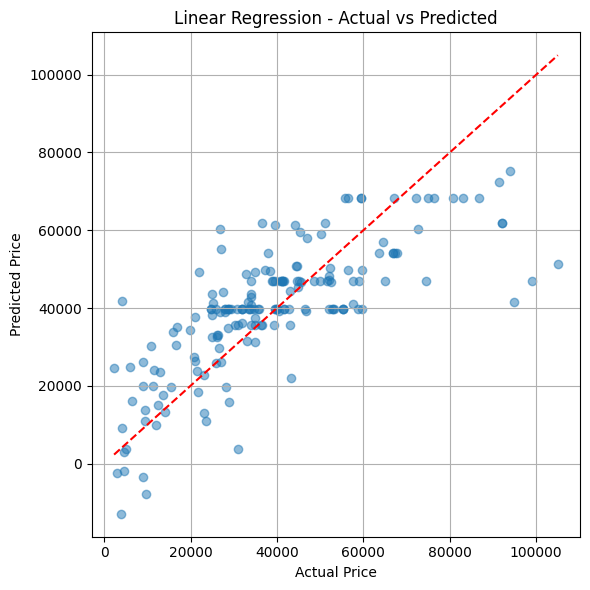

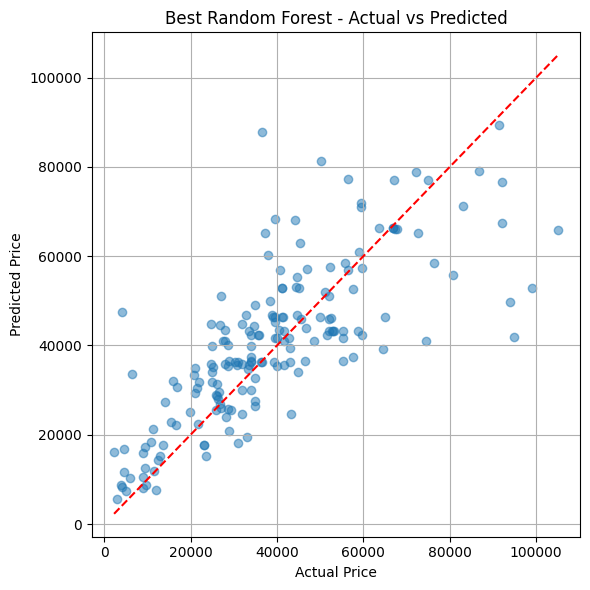

In [44]:
print(f"Linear Regression & RMSE: ${lr_rmse:.2f}, R^2: {lr_r2:.3f}")
print(f"Random Forest after feature engineering & RMSE: ${rf_rmse:.2f}, R²: {rf_r2:.3f}")
print(f"Tuned Random Forest & RMSE: ${best_rf_rmse:.2f}, R²: {best_rf_r2:.3f}")

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.grid(True)
    plt.tight_layout()

plot_predictions(y_test, lr_pred, "Linear Regression")
print("\n")
plot_predictions(y_test, best_rf_pred, "Best Random Forest")

##Important features

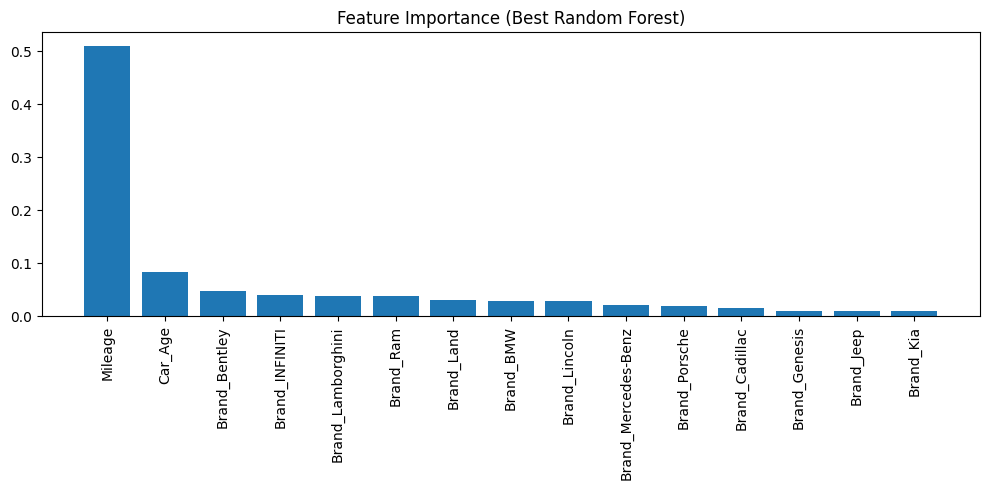

In [41]:
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_features])
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title("Feature Importance (Best Random Forest)")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), all_features[indices[:15]], rotation=90)
plt.tight_layout()
#Reference: https://github.com/catboost/catboost/issues/608
#Reference: https://www.youtube.com/watch?v=Cze3Oyy6XgM

We implemented a car price prediction system using two supervised learning models—Linear Regression and Random Forest Regressor—on a cleaned and preprocessed real-world dataset. It begins by loading the data, handling missing values (e.g., filling missing trims and mileages), and engineering features such as state location and separate city/highway MPG. Categorical variables like brand and drive train are one-hot encoded, while numeric values are standardized using a ColumnTransformer. The dataset is split into training and test sets, and both models are implemented via scikit-learn Pipelines to ensure consistent preprocessing. Linear Regression is trained and evaluated first, followed by Random Forest, with both models assessed using RMSE and R² metrics. Thank you for reviewing our code.